### Import Libraries

In [1]:
import sklearn
import pandas as pd
import numpy as np
import json

### Classes

In [2]:
import random
class Sentiment:
    NEGATIVE = 'NEGATIVE'
    NEUTRAL = 'NEUTRAL'
    POSITIVE = 'POSITIVE'


class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment(score)
        
    def get_sentiment(self, score):
        if self.score <=2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.POSITIVE
        
    def print_attributes(self):
        print(self.text)
        print(self.score)
        print(self.sentiment)
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [y.sentiment for y in self.reviews]
        
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        
         

### Load Data

In [3]:
# This is where it was originally collected
# https://jmcauley.ucsd.edu/data/amazon/

file_name = "C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/books_small_10000.json"
re = []
with open(file_name) as f:
    for line in f:
        allReview = json.loads(line)
        re.append(Review(allReview['reviewText'], allReview['overall']))

### Prep Data

In [4]:
from sklearn.model_selection import train_test_split
training, test = train_test_split(re, test_size=1/3, random_state=1)

training_container = ReviewContainer(training)
test_container = ReviewContainer(test)

training_container.evenly_distribute()
test_container.evenly_distribute()




In [5]:
train_x = training_container.get_text()
train_y = training_container.get_sentiment()

test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(test_y.count(Sentiment.POSITIVE))
print(test_y.count(Sentiment.NEGATIVE))


207
207


### Bags of Words vectorization

In [6]:
# Import Count Vectorizer
"""
NOTE: Before testing the data, the CountVectorizer was used. After testing, it seemed reasonable to use
TfidfVectorizer to improve accuracy of our model.
"""
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
# Convert training data into vectors
train_x_vectors = vectorizer.fit_transform(train_x)

# Convert testing data into vectors
test_x_vectors = vectorizer.transform(test_x)



### Classification

#### Linear SVM

In [7]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)
print(test_x[0])
clf_svm.predict(test_x_vectors[0])

Great combination of topics and characters.  Looking forward to pursuing many of these series.  Entertaining and enjoyable with the spectrum of paranormal fun.


array(['POSITIVE'], dtype='<U8')

#### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()

clf_dec.fit(train_x_vectors, train_y)
print(test_x[0])
clf_dec.predict(test_x_vectors[0])



Great combination of topics and characters.  Looking forward to pursuing many of these series.  Entertaining and enjoyable with the spectrum of paranormal fun.


array(['POSITIVE'], dtype='<U8')

#### Naive Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(train_x_vectors.toarray(), train_y)
print(test_x[0])
clf_gnb.predict(test_x_vectors[0].toarray())

Great combination of topics and characters.  Looking forward to pursuing many of these series.  Entertaining and enjoyable with the spectrum of paranormal fun.


array(['POSITIVE'], dtype='<U8')

#### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)
print(test_x[0])
clf_log.predict(test_x_vectors[0])

Great combination of topics and characters.  Looking forward to pursuing many of these series.  Entertaining and enjoyable with the spectrum of paranormal fun.


C:\Users\16475\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['POSITIVE'], dtype='<U8')

### Evaluation

In [11]:
# MEAN ACCURACY
# SVM Classifier
print(clf_svm.score(test_x_vectors,test_y))

# Decision Tree
print(clf_dec.score(test_x_vectors,test_y))

# Gaussian naive Bayes
print(clf_gnb.score(test_x_vectors.toarray(),test_y))

# Logistic Regression
print(clf_log.score(test_x_vectors,test_y))

0.8647342995169082
0.6932367149758454
0.6497584541062802
0.8671497584541062


In [12]:
# F1 SCORE:
"""
The F1 Score can be interpreted as a weighted average of precision and recall, where an F1 score of 1 is the best,
and 0 is the worst. The relative contribution of precision and recall to the F1 score are equal. The formula is:

    F1_score = 2*(precision*recall)/(preision + recall)
"""
from sklearn.metrics import f1_score
print("  Positve,  Negative")
# SVM Classifier
print(f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))
# Decision Tree
print(f1_score(test_y, clf_dec.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))

# Gaussian naive Bayes
print(f1_score(test_y, clf_gnb.predict(test_x_vectors.toarray()), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))

# Logistic Regression
print(f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))


  Positve,  Negative
[0.86666667 0.8627451 ]
[0.68796069 0.69833729]
[0.64197531 0.6572104 ]
[0.86873508 0.86552567]


### Tuning our Model (using Grid Search)

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf_svm_tuned = GridSearchCV(svc,parameters, cv=5)
clf_svm_tuned.fit(train_x_vectors, train_y)

C:\Users\16475\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\16475\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\16475\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\16475\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
print(clf_svm.score(test_x_vectors,test_y))
print(f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))


0.8647342995169082
[0.86666667 0.8627451 ]


### Saving our Model

In [15]:
import pickle

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/svm_tuned.pkl', 'wb') as f:
    pickle.dump(clf_svm_tuned, f)

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/decisionTree.pkl', 'wb') as f:
    pickle.dump(clf_dec, f)

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/gnb.pkl', 'wb') as f:
    pickle.dump(clf_gnb, f)
    
with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/logistic.pkl', 'wb') as f:
    pickle.dump(clf_log, f)
    

    



### Load Classifier

In [16]:
# To load the models into a different file. Run the code below
'''
import pickle
with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/svm_tuned.pkl', 'rb') as f:
    clf_svm_tuned = pickle.load(f))

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/decisionTree.pkl', 'rb') as f:
    cld_dec = pickle.load(f)

with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/gnb.pkl', 'rb') as f:
    clf_gnb = pickle.load(f)
    
with open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/logistic.pkl', 'rb') as f:
    clf_log = pickle.load(f)
'''

"\nimport pickle\nwith open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/vectorizer.pkl', 'rb') as f:\n    vectorizer = pickle.load(f)\n\nwith open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/svm_tuned.pkl', 'rb') as f:\n    clf_svm_tuned = pickle.load(f))\n\nwith open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/decisionTree.pkl', 'rb') as f:\n    cld_dec = pickle.load(f)\n\nwith open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/gnb.pkl', 'rb') as f:\n    clf_gnb = pickle.load(f)\n    \nwith open('C:/Users/16475/Desktop/IBM Data Science/Sklearn Practice/Models/logistic.pkl', 'rb') as f:\n    clf_log = pickle.load(f)\n"

### Confusion Matrix

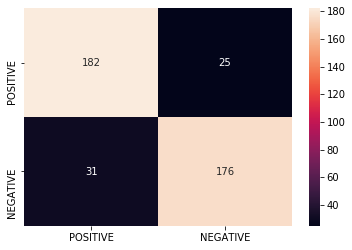

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf_svm_tuned.predict(test_x_vectors)
labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')
